In [ ]:
# %pip install --force-reinstall ../optpricerpy/dist/optpricerpy-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl

In [83]:
import pandas as pd
import xarray as xr
import pandera as pan
import optpricerpy
from optpricerpy.pricing_engine import (
    Measure,
    PricingEngine,
    ScenarioShift,
    RiskFactorFilter,
    MarketDataSchema
)
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Let construct a small portfolio of option trades. 
 1. We first read a csv of trades into a `pandas` dataframe.
 2. Then we construct the `Portfolio` object. This python objects acts as a wrapper around a native portfolio struct defined in rust.
 3. We then load the option trades into the portfolio in one bulk operation.

In [3]:
option_trades_df = pd.read_csv("option_trades.csv")
portfolio = optpricerpy.portfolio.Portfolio()
portfolio.load_option_trades(option_trades_df)
option_trades_df

,ticker,size,strike,option_type,expiry
0,AAPL,3000,160,call,2022-02-01
1,AAPL,3500,130,put,2022-04-01
2,MSFT,500,400,call,2023-01-01
3,TSLA,400,1100,call,2022-01-22
4,TSLA,300,1300,call,2023-01-01
5,TSLA,600,800,put,2023-01-01


Note that we get input validation and the api checks that the structure of our dataframe conforms

In [4]:
try:
    portfolio.load_option_trades(option_trades_df.rename(columns={"strike": "stricke"}))
except pan.errors.SchemaError as e:
    print(e)

error in check_types decorator of function 'load_option_trades': column 'strike' not in dataframe
  ticker  size  stricke option_type      expiry
0   AAPL  3000      160        call  2022-02-01
1   AAPL  3500      130         put  2022-04-01
2   MSFT   500      400        call  2023-01-01
3   TSLA   400     1100        call  2022-01-22
4   TSLA   300     1300        call  2023-01-01


We initialize a `MarketData` object and bulk load data for the tickers

In [5]:
marketdata_df = MarketDataSchema.validate(
    pd.read_csv("market_data.csv").set_index(["ticker", "date"])
)
md = optpricerpy.pricing_engine.MarketData()
md.load_market_data(marketdata_df)
marketdata_df

spot       vol
ticker date                             
AAPL   2019-01-02    38.326290  0.470640
       2019-01-03    34.508717  0.430503
       2019-01-04    35.981865  0.729828
       2019-01-07    35.901775  0.704121
       2019-01-08    36.586166  0.640321
...                        ...       ...
TSLA   2021-11-22  1156.869995  0.634511
       2021-11-23  1109.030029  0.607280
       2021-11-24  1116.000000  0.622948
       2021-11-26  1081.920044  0.593477
       2021-11-29  1136.989990  0.593619

[2936 rows x 2 columns]

In [37]:
valdates = (
    marketdata_df.index.get_level_values("date")
    .unique()
    .sort_values()
    .to_pydatetime()
)

The `PricingEngine` is the main entry to the calculation engine

In [38]:
pricing_engine = PricingEngine()

We can extract the full position image from the `Portfolio`.

In [39]:
sector_map = {
    "AAPL": "Technology",
    "MSFT": "Technology",
    "TSLA": "Automotive",
}
# augment the dataset with sector
posdata = portfolio.position_image().assign(sector=lambda x: x.ticker.map(sector_map))
posdata

,ticker,strike,expiry,option_type,sector
trade_id,,,,,
AAPL20220201C160_0,AAPL,160.0,2022-02-01,call,Technology
AAPL20220401P130_1,AAPL,130.0,2022-04-01,put,Technology
MSFT20230101C400_2,MSFT,400.0,2023-01-01,call,Technology
TSLA20220122C1100_3,TSLA,1100.0,2022-01-22,call,Automotive
TSLA20230101C1300_4,TSLA,1300.0,2023-01-01,call,Automotive
TSLA20230101P800_5,TSLA,800.0,2023-01-01,put,Automotive


Here we issue our first pricing request. We call into the engine requesting to price the supplied `Portfolio` object per the given daterange, using the supplied `MarketData`. 

In [40]:
metric_df = (
    pricing_engine.price_portfolio(
        [Measure.EXPOSURE, Measure.PRICE], valdates, portfolio, md
    )
    .unstack("measure")
    .droplevel(level=0, axis=1)
)
metric_df

measure                                exposure       price
trade_id           valuation_date                          
AAPL20220201C160_0 2019-01-02      4.011673e+05    1.034582
                   2019-01-03      4.231615e+05    0.416231
                   2019-01-04      2.279325e+05    5.110206
                   2019-01-07      2.366436e+05    4.513735
                   2019-01-08      2.667018e+05    3.391235
...                                         ...         ...
TSLA20230101P800_5 2021-11-22     -1.325011e+06  113.818213
                   2021-11-23     -1.315306e+06  113.947375
                   2021-11-24     -1.282871e+06  117.452483
                   2021-11-26     -1.308462e+06  114.297728
                   2021-11-29     -1.439304e+06  102.527690

[4404 rows x 2 columns]

Next we price the measure `exposure`, this time in a shifted context. We parameterize the calculation request with a volatility-shift

In [42]:
def _col_renamer(df):
    df.columns = [f"exposure_{c:.0%}" for c in df.columns]
    return df


vec_df = (
    pricing_engine.price_portfolio_ladder_scenario(
        [Measure.EXPOSURE],
        valdates,
        portfolio,
        md,
        ScenarioShift(
            Measure.VOL,
            None,
            rel_shifts=[0.0, 0.0, 0.0, 0.0],
            abs_shifts=[-0.05, -0.01, 0.01, 0.05],
        ),
    )
    .set_index(["trade_id", "valuation_date", "abs_shift"])
    .drop(columns=["measure", "rel_shift"])
    .unstack("abs_shift")
    .droplevel(level=0, axis=1)
    .pipe(_col_renamer)
)
vec_df.head().style.format(precision=0, thousands=" ")

Combine results to allow insights on a aggregated level

In [44]:
result_df = posdata.join(metric_df).join(vec_df)
result_df.head().style.format(precision=0, thousands=" ", formatter={"price": "{:0.2f}"})

In [45]:
exposure_cols = [
    "exposure_-5%",
    "exposure_-1%",
    "exposure",
    "exposure_1%",
    "exposure_5%",
]

Here we want to see the the portfolio sensitivity for the last valuation date broken by underlying ticker

In [57]:
by_ticker = (
    result_df.groupby("ticker")
    .tail(1)
    .pivot_table(
        index=["ticker", "valuation_date"],
        values=[
            "exposure",
            "exposure_-5%",
            "exposure_-1%",
            "exposure_1%",
            "exposure_5%",
        ],
        aggfunc="sum",
    )
)
by_ticker.head()[exposure_cols].style.format(precision=0, thousands=" ")

,,exposure_-5%,exposure_-1%,exposure,exposure_1%,exposure_5%
ticker,valuation_date,,,,,
AAPL,2021-11-29 00:00:00,-8 857 136,-6 989 466,-6 628 808,-6 299 996,-5 233 967
MSFT,2021-11-29 00:00:00,1 728 609,1 346 135,1 275 985,1 213 004,1 014 861
TSLA,2021-11-29 00:00:00,-1 641 781,-1 476 430,-1 439 304,-1 403 667,-1 274 391


or by sector

In [58]:
by_sector = (
    result_df.groupby("sector")
    .tail(1)
    .pivot_table(
        index=["sector", "valuation_date"],
        values=[
            "exposure",
            "exposure_-5%",
            "exposure_-1%",
            "exposure_1%",
            "exposure_5%",
        ],
        aggfunc="sum",
    )
)
by_sector[exposure_cols].style.format(precision=0, thousands=" ")

,,exposure_-5%,exposure_-1%,exposure,exposure_1%,exposure_5%
sector,valuation_date,,,,,
Automotive,2021-11-29 00:00:00,-1 641 781,-1 476 430,-1 439 304,-1 403 667,-1 274 391
Technology,2021-11-29 00:00:00,1 728 609,1 346 135,1 275 985,1 213 004,1 014 861


Lets look at the exposure scenario across time (using month-end values). Visualizing multiple timeseries (especially with a defined internal ordering) using line plots often gets messy. A nicer way is a lasagna plot.

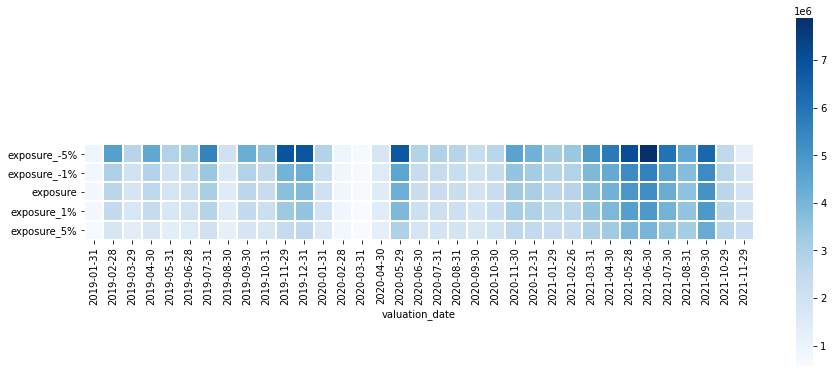

In [120]:
portfolio_df = (
    result_df.pivot_table(index="valuation_date", values=exposure_cols, aggfunc="sum")
    .pipe(lambda x: x.groupby([x.index.year, x.index.month]).tail(1))[exposure_cols]
    .T
)
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    portfolio_df,
    cmap="Blues",
    square=True,
    linewidth=0.3,
    cbar_kws={"shrink": 0.8},
    xticklabels=portfolio_df.columns.map(lambda t: t.strftime("%Y-%m-%d")),
)
plt.show()

When we apply more advanced scenarios in more dimensions than 1 it is no longer practical to use a regular dataframe representation. The engine returns a more appropriate `xarray.Dataset` object (which can be thought of as a higher dimensional dataframe). 

In [32]:
arr = (
    pricing_engine.price_portfolio_2d_matrix_scenario(
        [Measure.EXPOSURE],
        valdates[-1:],
        portfolio,
        md,
        x_shift=ScenarioShift(
            Measure.PRICE,
            RiskFactorFilter.EQUITY,
            rel_shifts=[-0.05, -0.01, 0, 0.01, 0.05],
            abs_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
        ),
        y_shift=ScenarioShift(
            Measure.VOL,
            None,
            rel_shifts=[-0.05, -0.01, 0, 0.01, 0.05],
            abs_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
        ),
    )
    .merge(xr.Dataset(posdata))
    .assign_coords(
        {
            "shift_price": [-0.05, -0.01, 0, 0.01, 0.05],
            "shift_vol": [-0.05, -0.01, 0, 0.01, 0.05],
        }
    )
)
arr

<xarray.Dataset>
Dimensions:         (valuation_date: 1, trade_id: 6, shift_price: 5, shift_vol: 5)
Coordinates:
  * valuation_date  (valuation_date) datetime64[ns] 2021-11-29
  * trade_id        (trade_id) <U19 'AAPL20220201C160_0' ... 'TSLA20230101P80...
  * shift_price     (shift_price) float64 -0.05 -0.01 0.0 0.01 0.05
  * shift_vol       (shift_vol) float64 -0.05 -0.01 0.0 0.01 0.05
Data variables:
    exposure        (valuation_date, trade_id, shift_price, shift_vol) float64 ...
    ticker          (trade_id) object 'AAPL' 'AAPL' 'MSFT' 'TSLA' 'TSLA' 'TSLA'
    strike          (trade_id) float64 160.0 130.0 400.0 1.1e+03 1.3e+03 800.0
    expiry          (trade_id) datetime64[ns] 2022-02-01 ... 2023-01-01
    option_type     (trade_id) object 'call' 'put' 'call' 'call' 'call' 'put'
    sector          (trade_id) object 'Technology' 'Technology' ... 'Automotive'

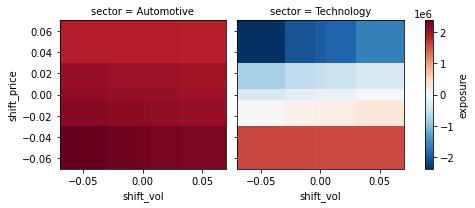

In [33]:
arr.groupby("sector").sum()["exposure"].plot(col="sector")

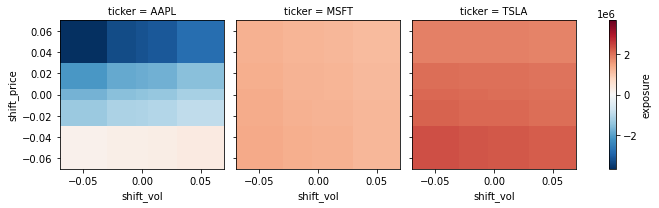

In [34]:
arr.groupby("ticker").sum()["exposure"].plot(col="ticker")

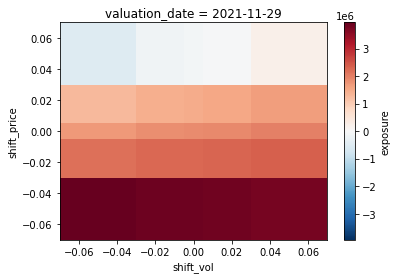

In [35]:
arr["exposure"].sum("trade_id").plot()